Analysis with equities tickers only 

In [1]:
import sys
sys.path.append('/Users/terrill/OneDrive/Documents/work/projects/spy/scripts/')
from equities.YahooScraper import Yahoo

import numpy as np
import pandas as pd
import pyodbc
import requests
import sqlalchemy
import time
from bs4 import BeautifulSoup
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

/Users/terrill/OneDrive/Documents/work/projects/spy/venv_spy/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# server connection

with open(f'/Users/terrill/Documents/work/stuff/spy_trend/sql_server_info_equities.txt', 'r') as f:
    line = f.readline().split(',')
name, user, password = line[0], line[3], line[4]

sqlalchemy.create_engine(f'mssql+pyodbc://{user}:{password}@{name}')
%load_ext sql
%sql mssql+pyodbc://$user:$password@$name
%config SqlMagic.displaycon = False

<h5>Cleaning up Yahoo data</h5>

In [3]:
def clean_yahoo_df(df, ticker):
    df.drop(['HighPrice','LowPrice','OpenPrice'], axis=1, inplace=True)
    df = df.astype({'ClosePrice': 'float'})
    df['ClosePrice'] = df['ClosePrice'].round(2)
    #df['Volume'] = df['Volume'].astype('int32')
    df.rename(columns={'Volume': f'{ticker}_Volume', 'ClosePrice': ticker}, inplace=True)
    df.set_index('Date', inplace=True)
    return df

In [4]:
%%capture

main_df = %sql select * from equities.dbo.spy order by date

main_df = clean_yahoo_df(main_df.DataFrame(), 'SPY')

In [5]:
main_df.tail()

,SPY,SPY_Volume
Date,,
2020-08-17,337.91,35481000
2020-08-18,338.64,38733900
2020-08-19,337.23,68054200
2020-08-20,338.28,42207800
2020-08-21,339.48,55065300


A few economic indicators are updated weekly, monthly, etc. Some of those days are on the weekend when equity markets are not opened. For that, we will have to outer join those dataframes with the main dataframes, forward fill the NaN data, and remove weekend dates. Below is the list of SPY dates that will be used later.

In [6]:
spy_dates = list(main_df.index)

Note, I will use Vanguard ETFs instead of SPDR even if SPY is an SPDR ETFs. Even though most of the SPDR ETFs are larger and more liquid I find the Vanguard ETFs more accurately reflects their respective idustries as the portfolios include small and mid caps. SPDR ETFs are heavily concentrated in stocks already included in SPY.

In [7]:
# VTI is vanguard total stock market index fund
equity_etf = ['QQQ', 'IWM', 'VTI']
vanguard_etf = ['VNQ', 'VGT', 'VHT', 'VFH', 'VCR', 'VIS', 'VDC', 'VPU', 'VDE', 'VAW', 'VOX']
# spdr_etfs = ['XLRE', 'XLK', 'XLV', 'XLF', 'XLY', 'XLI', 'XLP', 'XLU', 'XLE', 'XLB', 'XLC']
# USO over DBO because it has more volume
futures_etf = ['GLD', 'SLV', 'USO', 'UUP']
bond_etf = ['TLT', 'IEF', 'SHY']

In [8]:
%%capture

etf_list = [equity_etf, vanguard_etf, futures_etf, bond_etf]
full_etf_list = [j for i in etf_list for j in i]

for ticker in full_etf_list:
    query = %sql SELECT * FROM Equities.dbo.$ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

In [9]:
main_df.tail(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,VTI,VTI_Volume,VNQ,VNQ_Volume,...,USO,USO_Volume,UUP,UUP_Volume,TLT,TLT_Volume,IEF,IEF_Volume,SHY,SHY_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-19,337.23,68054200,276.10,31999400.0,156.40,14337300.0,171.30,2291000.0,79.99,4376200.0,...,30.66,3781500.0,25.13,1512800.0,163.73,12497700.0,121.68,4493800.0,86.52,2064900.0
2020-08-20,338.28,42207800,279.93,27723400.0,155.76,15413000.0,171.79,2184400.0,80.75,2949900.0,...,30.52,6112100.0,25.06,933200.0,165.21,10319900.0,122.03,2880300.0,86.52,2121000.0
2020-08-21,339.48,55065300,281.87,34356500.0,154.61,20552200.0,172.22,2284500.0,80.88,3380700.0,...,30.18,6520300.0,25.18,1667500.0,166.20,6836000.0,122.12,2103700.0,86.51,3337600.0


Joining VIX, VVIX, and DIX index to main_df

In [10]:
# VIX & DIX data
vix_index = ['I_VIX', 'I_VVIX']
dix = 'I_DIX'

def clean_VIX_df(df, ticker):
    df.drop(['HighPrice', 'LowPrice', 'OpenPrice'], axis=1, inplace=True)
    df = df.astype({'ClosePrice': 'float'})
    df['ClosePrice'] = df['ClosePrice'].round(2)
    df.set_index('Date', inplace=True)
    df.rename(columns={'ClosePrice': ticker}, inplace=True)
    return df

def clean_DIX_df(df):
    query = %sql SELECT * FROM Equities.dbo.I_DIX ORDER BY date
    df = query.DataFrame()
    df.drop(['SPX'], axis=1, inplace=True)
    df = df.astype({'DIX': 'float', 'GEX': 'float'})
    df.set_index('Date', inplace=True)
    return df

In [11]:
%%capture

for ticker in vix_index:
    query = %sql SELECT * FROM Equities.dbo.$ticker ORDER BY date DESC
    temp_df = clean_VIX_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

main_df = main_df.join(clean_DIX_df(dix), how='left')

In [12]:
# main_df.tail(3)

Tickers in S&P-500 broken down by industries

In [13]:
# grabbing list of tickers in sp500
yahoo = Yahoo()
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_table = payload[0]

In [14]:
# organizing tickers by industry
industries = sp500_table['GICS Sector'].unique()

tickers_by_industries = {}
for industry in industries:
    tickers_by_industries[industry] = sp500_table[sp500_table['GICS Sector'] == industry]['Symbol'].tolist()

In [15]:
# all tickers in the s&p
all_sp500_tickers = sp500_table['Symbol'].unique().tolist()

# modifying ticker exceptions
# will be using class A stocks instead and remove all class B stocks
all_sp500_tickers[all_sp500_tickers.index('BRK.B')] = 'BRK-A'
all_sp500_tickers[all_sp500_tickers.index('BF.B')] = 'BF-A'
b_stocks = ['GOOG', 'DISCK', 'FOX', 'NWS', 'UA']
for ticker in b_stocks:
    all_sp500_tickers.remove(ticker)

In [16]:
# start_date = '1990-01-01'
# end_date = str((datetime.now() - timedelta(days = 1)).date())

# sp500_df = pd.DataFrame() 

# count = 0
# for ticker in sorted(all_sp500_tickers):
#     temp_df = yahoo.get_data_from_range(ticker, start_date, end_date)
#     sp500_df[ticker] = temp_df['Adj Close']
#     sp500_df[f'{ticker}_Volume'] = temp_df['Volume']
#     time.sleep(2)

In [17]:
# sp500_df.head()
# sp500_df.columns

In [18]:
# will be saving the data locally just in case I need it. This will save time in pulling all the ticker data from yahoo
# haven't decided on saving the data to sql yet

# sp500_df.to_csv('/Users/terrill/OneDrive/Documents/work/projects/spy/data/sp500_df.csv')
# sp500_df = pd.read_csv('/Users/terrill/OneDrive/Documents/work/projects/spy/data/sp500_df.csv')

In [19]:
# main_df = main_df.join(sp500_df, how='left')

In [20]:
main_df.iloc[:,:].tail(2)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,VTI,VTI_Volume,VNQ,VNQ_Volume,...,TLT,TLT_Volume,IEF,IEF_Volume,SHY,SHY_Volume,I_VIX,I_VVIX,DIX,GEX
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-20,338.28,42207800,279.93,27723400.0,155.76,15413000.0,171.79,2184400.0,80.75,2949900.0,...,165.21,10319900.0,122.03,2880300.0,86.52,2121000.0,22.72,112.99,0.422101,1.005012e+10
2020-08-21,339.48,55065300,281.87,34356500.0,154.61,20552200.0,172.22,2284500.0,80.88,3380700.0,...,166.20,6836000.0,122.12,2103700.0,86.51,3337600.0,22.54,111.25,0.419865,3.109556e+09


Forward fill any data that is updated weekly, monthly, etc. Remove all dates when market is closed (weekends, holidays).

In [21]:
main_df.ffill(inplace=True)

In [22]:
main_df = main_df[main_df.index.isin(spy_dates)]
main_df.head(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,VTI,VTI_Volume,VNQ,VNQ_Volume,...,TLT,TLT_Volume,IEF,IEF_Volume,SHY,SHY_Volume,I_VIX,I_VVIX,DIX,GEX
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,26.18,1003200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.42,NaN,NaN,NaN
1993-02-01,26.37,480500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.33,NaN,NaN,NaN
1993-02-02,26.43,201300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.25,NaN,NaN,NaN


<h5>Last Value Multi-Step Method</h5>
For the direct multi-step time forcasting we will be predicting the target price for the next 15 days. To do this we will be creating columns for each day, shifiting the adjusted closing price value up by (t-n) days.

<h5>Rolling Mean and Standard Deviation</h5>
To be used later to inverse scaled predictions. We will be adding a rolling mean and standard deviation to each of the forward looking days. (probably a more efficient method exists -- all means and std could be shifted up as well)

Note: The goal is to project prices 30 days in advanced but we will start with 15 for now.

In [23]:
# number of days to project in the future
days_to_predict = 31

for i in range(1, days_to_predict+1):
    main_df[f'SPY_target_{i}d'] = main_df['SPY'].shift(-i)
    main_df[f'SPY_mean_{i}d'] = main_df[f'SPY_target_{i}d'].rolling(window=5, min_periods=1).mean()
    main_df[f'SPY_std_{i}d'] = main_df[f'SPY_target_{i}d'].rolling(window=5, min_periods=1).std()
    
# SPY_target = pd.DataFrame()
# SPY_target['SPY'] = main_df['SPY']
    
main_df.drop(main_df.tail(1).index, inplace=True)
main_df.drop('SPY', axis=1, inplace=True)

In [24]:
main_df.tail(3)

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,VTI,VTI_Volume,VNQ,VNQ_Volume,VGT,...,SPY_std_28d,SPY_target_29d,SPY_mean_29d,SPY_std_29d,SPY_target_30d,SPY_mean_30d,SPY_std_30d,SPY_target_31d,SPY_mean_31d,SPY_std_31d
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-18,38733900,277.97,23529500.0,156.39,14670400.0,171.97,3551400.0,81.42,3635300.0,306.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-19,68054200,276.10,31999400.0,156.40,14337300.0,171.30,2291000.0,79.99,4376200.0,306.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-20,42207800,279.93,27723400.0,155.76,15413000.0,171.79,2184400.0,80.75,2949900.0,310.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h5>Handling Null Values</h5>
<br>
I have decided to drop any rows with NaN. There are a few tickers that was created way after the SPY etf was created. Will experiment with removing a few of those tickers for the analysis.
<br>

In [25]:
# the first row without null values
first_non_null_entry = main_df[~main_df.isnull().any(axis=1)].index[0]
first_non_null_entry

datetime.date(2011, 5, 2)

In [26]:
# main_df.isna().sum().sort_values(ascending=False).head(5)

In [27]:
main_df = main_df.loc[main_df.index >= first_non_null_entry]
main_df.index = pd.to_datetime(main_df.index,format='%Y-%m-%d')
main_df.head(3)

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,VTI,VTI_Volume,VNQ,VNQ_Volume,VGT,...,SPY_std_28d,SPY_target_29d,SPY_mean_29d,SPY_std_29d,SPY_target_30d,SPY_mean_30d,SPY_std_30d,SPY_target_31d,SPY_mean_31d,SPY_std_31d
Date,,,,,,,,,,,,,,,,,,,,,
2011-05-02,126278700,53.47,48149400.0,74.63,48962400.0,58.95,1506000.0,42.62,2434500.0,58.87,...,0.583370,105.98,106.570,0.649115,107.32,106.630,0.711934,105.41,106.398,0.900428
2011-05-03,138375000,53.22,38100000.0,73.69,56070000.0,58.62,1150000.0,42.26,2052900.0,58.56,...,0.649115,107.32,106.630,0.711934,105.41,106.398,0.900428,105.65,106.050,0.743808
2011-05-04,182678500,53.14,53097200.0,72.74,64754600.0,58.19,1715100.0,42.02,1650200.0,58.39,...,0.711934,105.41,106.398,0.900428,105.65,106.050,0.743808,105.96,106.064,0.740696


<h5>Splitting data into train, validation, test sets</h5>

In [28]:
# validation size
valid_size = int(len(main_df) * 0.2)
train_size = len(main_df) - valid_size

train = main_df.iloc[:train_size - days_to_predict].copy()
valid = main_df.iloc[train_size - days_to_predict:train_size + valid_size - days_to_predict].copy()
train_valid = main_df.iloc[:train_size + valid_size - days_to_predict].copy()
test = main_df.iloc[-days_to_predict].copy()
actual_results = main_df.iloc[-days_to_predict+1:].copy()

# set date ranges
# train: 2011-05-02:2018-08-27
# valid: 2018-08-28:2020-07-08
# train_valid: 2011-05-02:2020-07-08
# test: 2020-07-09
# actual_results: 2020-07-10:2020-08-20
# actual_results.isna().sum().sort_values(ascending=False).head(30)

In [29]:
features = [i for i in main_df.columns if 'target' not in i and 'mean' not in i and 'std' not in i]
target = [i for i in main_df.columns if 'target' in i]

In [30]:
# non-scaled data
X_train = train[features]
X_valid = valid[features]
X_train_valid = train_valid[features]
X_test = test[features]

y_train = train[target]
y_valid = valid[target]
y_train_valid = train_valid[target]
y_test = test[target]


print('Features')
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'X_train_valid shape: {X_train_valid.shape}')
print(f'X_test shape: {X_test.shape}')

print('\nTargets')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')
print(f'y_train_valid shape: {y_train_valid.shape}')
print(f'y_test shape: {y_test.shape}')

Features
X_train shape: (1844, 47)
X_valid shape: (468, 47)
X_train_valid shape: (2312, 47)
X_test shape: (47,)

Targets
y_train shape: (1844, 31)
y_valid shape: (468, 31)
y_train_valid shape: (2312, 31)
y_test shape: (31,)


<h5>Normalizing Data</h5>

In [31]:
from sklearn.preprocessing import StandardScaler

def scale_data(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    return df_scaled

In [32]:
# scaling train and train_valid data
X_train_scaled = scale_data(X_train)
y_train_scaled = scale_data(y_train)
X_train_valid_scaled = scale_data(X_train_valid)
y_train_valid_scaled = scale_data(y_train_valid)

X_valid_scaled = scale_data(X_valid)

print(f'X_train shape: {X_train_scaled.shape}')
print(f'y_train shape: {y_train_scaled.shape}')
print(f'X_train_valid shape: {X_train_valid_scaled.shape}')
print(f'y_train_valid shape: {y_train_valid_scaled.shape}')
print(f'\nX_valid_scaled: {X_valid_scaled.shape}')

X_train shape: (1844, 47)
y_train shape: (1844, 31)
X_train_valid shape: (2312, 47)
y_train_valid shape: (2312, 31)

X_valid_scaled: (468, 47)


In [33]:
# normalize = (test[cols_to_normalize[:-15]] - test['SPY_mean_1d']) / test['SPY_std_1d']
# inverse = normalize * test['SPY_std_1d'] + test['SPY_mean_1d']

Normalizing the test set will have to be done manually as there will only be one observation. Using StandardScaler() will turn all numbers to zero.

Normalize the numbers by applying the below formula to the observations using the mean and standard deviation calculations according to the number of days to forecast. Above is an example.

eg... application and inverse<br>
z = (x - u) / s<br>
x = z * s + u

<h5>Setting Up Model Functions</h5>

In [34]:
# direct
def run_direct_model(model, X_train_scaled, y_train_scaled, X_test_scaled, train_df):
    results = pd.DataFrame()
    
    for day in range(1, days_to_predict+1):
        model.fit(X_train_scaled, y_train_scaled[f'SPY_target_{day}d'])
        prediction = model.predict(X_test_scaled)
        inversed_scaled_predictions = prediction * train_df[f'SPY_std_{day}d'] + train_df[f'SPY_mean_{day}d']
        results[f'SPY_target_{day}d'] = inversed_scaled_predictions
    
    return results

# recursive
def run_recursive_model(model, X_train_scaled, y_train_scaled, X_test_scaled, train_df):
    results = pd.DataFrame()
    y_train_scaled_day = list(y_train_scaled['SPY_target_1d'])

    for day in range(1, days_to_predict):
        model.fit(X_train_scaled, y_train_scaled_day)
        predictions = model.predict(X_test_scaled)
        inversed_scaled_predictions = predictions * train_df[f'SPY_std_{day}d'] + train_df[f'SPY_mean_{day}d']
        results[f'SPY_target_{day}d'] = inversed_scaled_predictions

        next_day_targets = list(y_train_scaled[f'SPY_target_{day+1}d'].iloc[:-1])
        next_day_targets.append(predictions[0])
        y_train_scaled_day = next_day_targets
        
    return results

In [107]:
# scoring & plotting
from sklearn.metrics import mean_squared_error
import math

def rmse_scores(results, y_train):
    rmse_results = []
    for day in range(1, days_to_predict):
        rmse_score = math.sqrt(mean_squared_error(y_train[f'SPY_target_{day}d'], results[f'SPY_target_{day}d']))
        rmse_results.append(rmse_score)
        
    return rmse_results

def plot_results(rmse_results, ax):
    ax.plot(list(range(1, days_to_predict)), rmse_results, marker='s')
    
    ax.grid(True)
    ax.set_xlabel('days')
    ax.set_ylabel('rmse')
    ax.set_facecolor('white')

<h5>Models</h5>

In [44]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

models = {}

models['lasso'] = Lasso(random_state=0)
models['sgd_regressor'] = SGDRegressor(random_state=0)
models['svr'] = SVR()
models['xgboost'] = XGBRegressor(random_state=0)

In [37]:
# model_testing = list(models.keys())
# train
# X_train_scaled[X_train_scaled.isna().any(axis=1)]
# df[df.isna().any(axis=1)]

<h5>Predicting with training set</h5>

In [45]:
train_predictions_direct = {}
train_rmse_direct = {}
train_predictions_recursive = {}
train_rmse_recursive = {}

for name, model in models.items():
    direct_results = run_direct_model(model, X_train_scaled, y_train_scaled, X_train_scaled, train)
    recursive_results = run_recursive_model(model, X_train_scaled, y_train_scaled, X_train_scaled, train)
    
    train_predictions_direct[name] = direct_results
    train_predictions_recursive[name] = recursive_results
    
    train_rmse_direct[name] = rmse_scores(direct_results, y_train)
    train_rmse_recursive[name] = rmse_scores(recursive_results, y_train)

In [95]:
# train_predictions_recursive

Text(0.5, 1.0, 'RMSE Recursive - Training Set Model Performance')

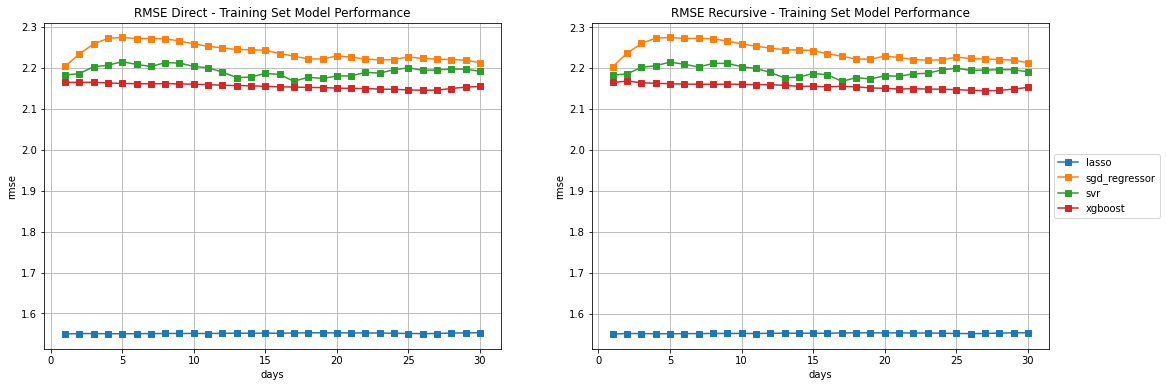

In [110]:
# plotting results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=True, sharey=True)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

legend_list = []

for name, model in models.items():
    legend_list.append(name)
    plot_results(train_rmse_direct[name], ax1)
    plot_results(train_rmse_recursive[name], ax2)
    
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
ax1.set_title('RMSE Direct - Training Set Model Performance')
ax2.set_title('RMSE Recursive - Training Set Model Performance')

In [ ]:
train_rmse_results = pd.DataFrame(index=range(1, days_to_predict+1))

for name in models.keys():
    rmse_per_day = []
    for day in range(1, days_to_predict+1):
        rmse_score = math.sqrt(mean_squared_error(y_train[f'SPY_target_{day}d'], train_results[name][day]))
        rmse_per_day.append(rmse_score)
    train_rmse_results[name] = rmse_per_day
    
train_rmse_results.tail(2)

In [ ]:
# # plotting results
rcParams['figure.figsize'] = 12, 6

legend_list = ['lasso']
ax = train_rmse_results['lasso'].plot(x='days', y='rmse', marker='s', grid=True)

for col in train_rmse_results.columns[1:]:
    ax = train_rmse_results[col].plot(x='x', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(col)

# ax = train_rmse_results[model_testing].plot(style='b', marker='s', grid=True)

ax.set_xlabel('days')
ax.set_ylabel('rmse')
ax.set_title('RMSE - Training Set Model Performance')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

<h5>Predicting with validation set</h5>

In [ ]:
valid_results = {}

for model in models:
    valid_results[model] = {}

for name, model in models.items():
    valid_results[name] = {}
    for day in range(1, days_to_predict+1):
#         print(name, day)
        model.fit(X_train_scaled, y_train_scaled[f'SPY_target_{day}d'])
        prediction = model.predict(X_valid_scaled)
        prediction = prediction * valid[f'SPY_std_{day}d'] + valid[f'SPY_mean_{day}d']
        valid_results[name][day] = prediction

In [ ]:
valid_rmse_results = pd.DataFrame(index=range(1, days_to_predict+1))

for name in models.keys():
    rmse_per_day = []
    for day in range(1, days_to_predict+1):
        rmse_score = math.sqrt(mean_squared_error(y_valid[f'SPY_target_{day}d'], valid_results[name][day]))
        rmse_per_day.append(rmse_score)
    valid_rmse_results[name] = rmse_per_day
    
valid_rmse_results.tail(2)

In [ ]:
# # plotting results
rcParams['figure.figsize'] = 12, 6

legend_list = ['lasso']

ax = valid_rmse_results['lasso'].plot(x='days', y='rmse', marker='s', grid=True)

for col in valid_rmse_results.columns[1:]:
    ax = valid_rmse_results[col].plot(x='x', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(col)
    
# ax = valid_rmse_results[model_testing].plot(style='b', marker='s', grid=True)

ax.set_xlabel('days')
ax.set_ylabel('rmse')
ax.set_title('RMSE - Validation Set Model Performance')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

<h5>Predicting with test set</h5>

In [2093]:
# preparing test set

# scaling
scaling_set = valid.iloc[-4:].append(test)
scaling_set = scaling_set[scaling_set.columns.drop(list(scaling_set.filter(regex='mean')))
                                             .drop(list(scaling_set.filter(regex='std')))
                                             .drop(list(scaling_set.filter(regex='target')))][cols_to_normalize[:-days_to_predict]]
mean_set = scaling_set.mean()
# replace any zero value with a really small number to avoid zero division in case close value does not change over N days
std_set = scaling_set.std().replace(0, 0.001)
X_test_scaled = test[cols_to_normalize[:-days_to_predict]]
X_test_scaled = (X_test_scaled - mean_set) / std_set

# adding the rest of features that were not scaled
temp = test.drop(cols_to_normalize).drop(test.filter(regex='mean').index).drop(test.filter(regex='std').index)
X_test_scaled = X_test_scaled.append(temp)

# reordering the series based on X_train_valid_scaled column order
# reshaping the sample
X_test_scaled = X_test_scaled.reindex(features)
X_test_scaled = X_test_scaled.values.reshape(1, -1)

In [2094]:
# predicting the next 15 days with the most optimal models per day
optimal_models_per_day = valid_rmse_results.idxmin(axis=1)

test_results = []
for day in range(1, days_to_predict+1):
    optimal_model = optimal_models_per_day.loc[day]
    model = models[optimal_model].fit(X_train_valid_scaled, y_train_valid_scaled[f'SPY_target_{day}d'])
    
    prediction = model.predict(X_test_scaled)
    prediction = prediction * test[f'SPY_std_{day}d'] + test[f'SPY_mean_{day}d']
    test_results.append(prediction[0])
# test_results
# optimal_models_per_day

In [2096]:
rmse_score = math.sqrt(mean_squared_error(actual_results['SPY_target_1d'], test_results))
print(f'{days_to_predict} day prediction RMSE score: {rmse_score}')

30 day prediction RMSE score: 6.648749456351295


Text(0.5, 1.0, 'Test Predictions')

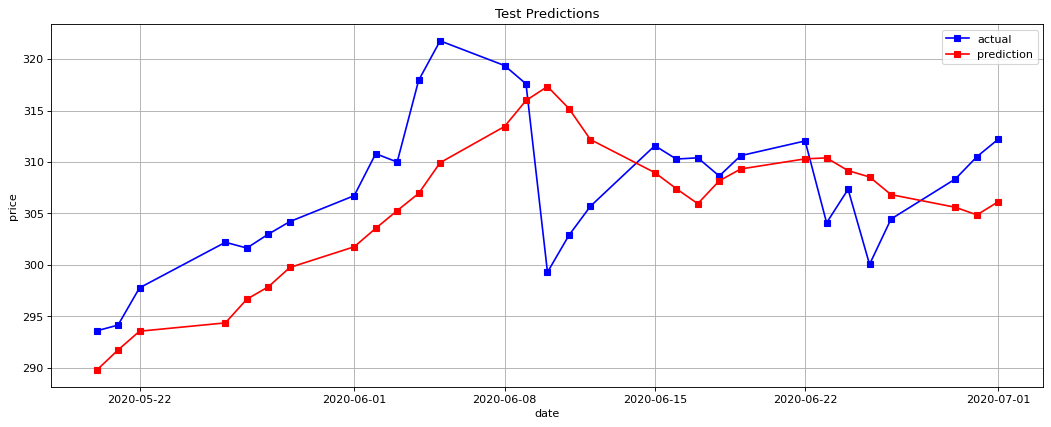

In [2097]:
# plot the rmse results and the predictions/actual data
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

# ax = actual_results['SPY_target_1d'].plot(style='b', marker='s', grid=True)
# ax1 = plt.plot(actual_results.index, test_results, color='r', marker='s')
plt.plot(actual_results.index, actual_results['SPY_target_1d'], color='b', marker='s')
plt.plot(actual_results.index, test_results, color='r', marker='s')

plt.grid()
plt.legend(['actual', 'prediction'])
plt.xlabel('date')
plt.ylabel('price')
plt.title('Test Predictions')

In [ ]:
# set date ranges
# train: 2004-09-29:2017-03-23
# valid: 2017-03-24:2020-05-18
# train_valid: 2004-09-29:2020-05-18
# test: 2020-05-19
# actual_results: 2020-05-20:2020-07-01

Final 30 day predictions RSME: 6.65.

There is a slight lag in predictions, especially during major reversals of the market.

For this iteration I created a 30 day prediction using the direct multi-step forecast strategy.

This analysis excludes the DIX and GEX index.

After making a few minor tuning to the parameters of each model I was able to slightly improve performance but overall performance did not improve. The Lasso model continued to outperform the rest of the algorithms even without parameter tuning. Note, parameters used for XGBoost model was pulled from previous iterations that contained more in-depth tuning.


The next steps to improving this model:
- predict the next 15/30 days using recursive strategy
- break out each financial feature groups and filter out the low performing ones
- feature engineering (add industry ticker data and volume, % change, etc.)
- explore other scaling methods

To do list:
- write scripts that will continuously upload new data into server
- explore adding options data if possible
- try DNN models (tensorflow) 